# 🚀 OPTIMIZED REVENUE FORECASTING WITH ELASTICNET

## CRITICAL DOMAIN KNOWLEDGE:
1. **actual_revenue**: Revenue for ONE month only. Always use `shift(1)` - we don't have current month's actual.
2. **committed_signed/unsigned, wtd_pipeline**: CUMULATIVE M→Dec values (sum of remaining months). Always DECREASING.
3. **Units are DIFFERENT**: Cannot directly mix actual_revenue (1 month) with cumulative columns.
4. **avg_prob_pct**: Standalone feature - don't combine with other columns.

## KEY INSIGHT FOR DELTA FEATURES:
Since cumulative values are always decreasing, we can create:
- `committed_signed_m - committed_signed_m-1` = change in cumulative (shows how much was added/removed)
- These delta features capture the MONTHLY contribution to the forecast

## UNDERPREDICTION FIX:
- Added bias correction after model training
- Added new momentum and decay features to capture growth trends
- Removed volatile negative-impact features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

pd.set_option('display.float_format', lambda x: f'{x:.2f}')
print('✅ Libraries imported!')

✅ Libraries imported!


In [2]:
# Load data
df = pd.read_csv('mon_final.csv', index_col=0)
df = df.sort_values(['year', 'month_num']).reset_index(drop=True)
print(f'Dataset shape: {df.shape}')
print(f'Years: {sorted(df["year"].unique())}')
print(f'Columns: {list(df.columns)}')

Dataset shape: (33, 9)
Years: [np.int64(2023), np.int64(2024), np.int64(2025)]
Columns: ['year', 'month', 'month_num', 'actual_revenue', 'wtd_pipeline_revenue', 'committed_unsig_revenue', 'committed_sign_revenue', 'avg_prob_pct', 'date']


In [3]:
def create_comprehensive_features(df):
    """
    Create comprehensive domain-specific features following strict business rules.

    CRITICAL RULES:
    1. actual_revenue: Always shift(1) - we don't have current month's actual
    2. committed_signed/unsigned, wtd_pipeline: Cumulative M→Dec, normalize by remaining_months
    3. DELTA FEATURES: committed_m - committed_m-1 captures monthly change in forecast
    4. avg_prob_pct: Standalone feature

    NEW FEATURES ADDED:
    - signed_decayed: Exponential decay based on remaining months
    - revenue_macd: MACD-style momentum indicator
    - log_signed_monthly: Log transform of signed monthly run rate
    - pipeline_forecast_volatility: 3-month rolling std of pipeline % change
    - unsigned_monthly_run_rate: Unsigned deals per remaining month
    """
    df_feat = df.copy().sort_values(['year', 'month_num']).reset_index(drop=True)
    print('\n' + '='*80)
    print('COMPREHENSIVE FEATURE ENGINEERING')
    print('='*80)

    # ========== TIER 1: TIME CONTEXT ==========
    print('\n📊 TIER 1: Time Context Features')
    df_feat['remaining_months'] = 13 - df_feat['month_num']  # Jan=12, Dec=1
    df_feat['year_progress'] = (df_feat['month_num'] - 1) / 11  # 0 to 1 scale
    df_feat['quarter'] = ((df_feat['month_num'] - 1) // 3) + 1
    df_feat['quarter_progress'] = ((df_feat['month_num'] - 1) % 3) / 2  # 0, 0.5, 1
    df_feat['time_pressure'] = 1 / (df_feat['remaining_months'] + 0.5)  # Higher as year ends
    df_feat['quarter_intensity'] = df_feat['quarter'].map({1: 0.85, 2: 0.95, 3: 1.0, 4: 1.15})
    df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month_num'] / 12)
    df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month_num'] / 12)
    df_feat['is_quarter_end'] = df_feat['month_num'].isin([3, 6, 9, 12]).astype(int)
    print(f'  Created 9 time context features')

    # ========== TIER 2: DENSITY METRICS (Normalize cumulative by remaining months) ==========
    print('\n📊 TIER 2: Density Metrics (Scale-Invariant)')
    df_feat['signed_density'] = df_feat['committed_sign_revenue'] / df_feat['remaining_months']
    df_feat['unsigned_density'] = df_feat['committed_unsig_revenue'] / df_feat['remaining_months']
    df_feat['pipeline_density'] = df_feat['wtd_pipeline_revenue'] / df_feat['remaining_months']
    df_feat['total_committed'] = df_feat['committed_sign_revenue'] + df_feat['committed_unsig_revenue']
    df_feat['total_committed_density'] = df_feat['total_committed'] / df_feat['remaining_months']
    df_feat['total_forecast'] = df_feat['total_committed'] + df_feat['wtd_pipeline_revenue']
    df_feat['total_forecast_density'] = df_feat['total_forecast'] / df_feat['remaining_months']

    # NEW: Monthly run rates
    df_feat['signed_monthly_run_rate'] = df_feat['committed_sign_revenue'] / df_feat['remaining_months']
    df_feat['unsigned_monthly_run_rate'] = df_feat['committed_unsig_revenue'] / df_feat['remaining_months']
    df_feat['pipeline_monthly_run_rate'] = df_feat['wtd_pipeline_revenue'] / df_feat['remaining_months']
    print(f'  Created 10 density features')

    # ========== TIER 3: NEW RESEARCH-BASED FEATURES ==========
    print('\n📊 TIER 3: Research-Based Features (NEW)')

    # 1. SIGNED DECAYED - Exponential decay for deals far in the future
    # Deals signed but far in future are less reliable
    df_feat['forecast_decay_factor'] = np.exp(-0.15 * (df_feat['remaining_months'] - 1))
    df_feat['signed_decayed'] = df_feat['committed_sign_revenue'] * df_feat['forecast_decay_factor']
    df_feat['unsigned_decayed'] = df_feat['committed_unsig_revenue'] * df_feat['forecast_decay_factor']
    df_feat['pipeline_decayed'] = df_feat['wtd_pipeline_revenue'] * df_feat['forecast_decay_factor']

    # 2. REVENUE MACD - Short-term trend minus long-term trend (momentum indicator)
    df_feat['revenue_macd'] = (
        df_feat['actual_revenue'].shift(1).ewm(span=3, adjust=False).mean() -
        df_feat['actual_revenue'].shift(1).ewm(span=6, adjust=False).mean()
    )
    df_feat['revenue_macd_signal'] = df_feat['revenue_macd'].ewm(span=3, adjust=False).mean()
    df_feat['revenue_macd_histogram'] = df_feat['revenue_macd'] - df_feat['revenue_macd_signal']

    # 3. LOG SIGNED MONTHLY - Compress extreme values
    df_feat['log_signed_monthly'] = np.log1p(df_feat['signed_monthly_run_rate'])
    df_feat['log_unsigned_monthly'] = np.log1p(df_feat['unsigned_monthly_run_rate'])
    df_feat['log_pipeline_monthly'] = np.log1p(df_feat['pipeline_monthly_run_rate'])

    # 4. PIPELINE FORECAST VOLATILITY - 3-month rolling std of pipeline % change
    df_feat['pipeline_pct_change'] = df_feat['wtd_pipeline_revenue'].pct_change()
    df_feat['pipeline_forecast_volatility'] = df_feat['pipeline_pct_change'].rolling(3, min_periods=1).std()
    df_feat['signed_forecast_volatility'] = df_feat['committed_sign_revenue'].pct_change().rolling(3, min_periods=1).std()

    # 5. VELOCITY FEATURES - Rate of change in forecast
    df_feat['pipeline_velocity'] = df_feat['wtd_pipeline_revenue'].diff(1) / df_feat['remaining_months']
    df_feat['signed_velocity'] = df_feat['committed_sign_revenue'].diff(1) / df_feat['remaining_months']

    # 6. COVERAGE RATIOS - How much of required revenue is covered
    historical_avg = df_feat['actual_revenue'].shift(1).rolling(12, min_periods=1).mean()
    df_feat['signed_coverage'] = df_feat['signed_density'] / (historical_avg + 1e-10)
    df_feat['total_coverage'] = df_feat['total_forecast_density'] / (historical_avg + 1e-10)

    # 7. MOMENTUM STRENGTH - Trend acceleration
    df_feat['revenue_trend_strength'] = df_feat['revenue_macd'].abs() / (df_feat['actual_revenue'].shift(1).rolling(6, min_periods=1).std() + 1e-10)

    print(f'  Created 18 research-based features')

    # ========== TIER 4: DELTA FEATURES (KEY INNOVATION) ==========
    print('\n📊 TIER 4: Delta Features (Monthly Changes in Cumulative)')
    # These capture how much the cumulative forecast changed from month to month
    # Negative delta = some deals closed/removed, Positive delta = new deals added

    # Delta from M to M-1 (1-month change)
    df_feat['signed_delta_1m'] = df_feat['committed_sign_revenue'].diff(1)
    df_feat['unsigned_delta_1m'] = df_feat['committed_unsig_revenue'].diff(1)
    df_feat['pipeline_delta_1m'] = df_feat['wtd_pipeline_revenue'].diff(1)
    df_feat['total_forecast_delta_1m'] = df_feat['total_forecast'].diff(1)

    # Delta from M to M-2 (2-month change)
    df_feat['signed_delta_2m'] = df_feat['committed_sign_revenue'].diff(2)
    df_feat['unsigned_delta_2m'] = df_feat['committed_unsig_revenue'].diff(2)
    df_feat['pipeline_delta_2m'] = df_feat['wtd_pipeline_revenue'].diff(2)

    # Delta from M to M-3 (3-month/quarter change)
    df_feat['signed_delta_3m'] = df_feat['committed_sign_revenue'].diff(3)
    df_feat['pipeline_delta_3m'] = df_feat['wtd_pipeline_revenue'].diff(3)

    # Delta density (change per remaining month)
    df_feat['signed_density_delta_1m'] = df_feat['signed_density'].diff(1)
    df_feat['pipeline_density_delta_1m'] = df_feat['pipeline_density'].diff(1)

    # Acceleration of deltas (2nd derivative)
    df_feat['signed_delta_acceleration'] = df_feat['signed_delta_1m'].diff(1)
    df_feat['pipeline_delta_acceleration'] = df_feat['pipeline_delta_1m'].diff(1)
    print(f'  Created 13 delta features')

    # ========== TIER 5: RATIO FEATURES (Scale-Invariant) ==========
    print('\n📊 TIER 5: Ratio Features')
    df_feat['signed_to_total_ratio'] = df_feat['committed_sign_revenue'] / (df_feat['total_committed'] + 1e-10)
    df_feat['signed_to_forecast_ratio'] = df_feat['committed_sign_revenue'] / (df_feat['total_forecast'] + 1e-10)
    df_feat['pipeline_to_committed_ratio'] = df_feat['wtd_pipeline_revenue'] / (df_feat['total_committed'] + 1e-10)
    df_feat['unsigned_to_signed_ratio'] = df_feat['committed_unsig_revenue'] / (df_feat['committed_sign_revenue'] + 1e-10)
    df_feat['signed_density_to_forecast_density'] = df_feat['signed_density'] / (df_feat['total_forecast_density'] + 1e-10)

    # NEW: Conversion ratios
    df_feat['conversion_potential'] = df_feat['unsigned_density'] / (df_feat['signed_density'] + 1e-10)
    df_feat['pipeline_to_signed_ratio'] = df_feat['pipeline_density'] / (df_feat['signed_density'] + 1e-10)
    print(f'  Created 7 ratio features')

    # ========== TIER 6: LAGGED REVENUE (CRITICAL: always shift(1)+) ==========
    print('\n📊 TIER 6: Lagged Revenue Features (shift(1) for all)')
    for lag in [1, 2, 3, 6, 12]:
        df_feat[f'revenue_lag_{lag}'] = df_feat['actual_revenue'].shift(lag)

    # Lagged density features
    for lag in [1, 2, 3]:
        df_feat[f'signed_density_lag_{lag}'] = df_feat['signed_density'].shift(lag)
        df_feat[f'pipeline_density_lag_{lag}'] = df_feat['pipeline_density'].shift(lag)

    # NEW: Lagged MACD
    df_feat['revenue_macd_lag_1'] = df_feat['revenue_macd'].shift(1)
    print(f'  Created 12 lagged features')

    # ========== TIER 7: ROLLING STATISTICS (Using shift(1) to avoid leakage) ==========
    print('\n📊 TIER 7: Rolling Statistics')
    for window in [3, 6, 12]:
        df_feat[f'revenue_rolling_mean_{window}'] = df_feat['actual_revenue'].shift(1).rolling(window=window, min_periods=1).mean()
        df_feat[f'revenue_rolling_std_{window}'] = df_feat['actual_revenue'].shift(1).rolling(window=window, min_periods=1).std()
        df_feat[f'revenue_rolling_min_{window}'] = df_feat['actual_revenue'].shift(1).rolling(window=window, min_periods=1).min()
        df_feat[f'revenue_rolling_max_{window}'] = df_feat['actual_revenue'].shift(1).rolling(window=window, min_periods=1).max()

    for window in [3, 6]:
        df_feat[f'signed_density_rolling_mean_{window}'] = df_feat['signed_density'].rolling(window=window, min_periods=1).mean()
        df_feat[f'pipeline_density_rolling_mean_{window}'] = df_feat['pipeline_density'].rolling(window=window, min_periods=1).mean()

    # NEW: Rolling range (max - min) captures volatility
    df_feat['revenue_rolling_range_6'] = df_feat['revenue_rolling_max_6'] - df_feat['revenue_rolling_min_6']
    print(f'  Created 17 rolling features')

    # ========== TIER 8: EWM FEATURES ==========
    print('\n📊 TIER 8: EWM Features')
    for span in [3, 6, 12]:
        df_feat[f'revenue_ewm_{span}'] = df_feat['actual_revenue'].shift(1).ewm(span=span, min_periods=1).mean()

    df_feat['signed_density_ewm_6'] = df_feat['signed_density'].ewm(span=6, min_periods=1).mean()
    df_feat['pipeline_density_ewm_6'] = df_feat['pipeline_density'].ewm(span=6, min_periods=1).mean()
    df_feat['total_forecast_density_ewm_6'] = df_feat['total_forecast_density'].ewm(span=6, min_periods=1).mean()

    # EWM of deltas
    df_feat['signed_delta_ewm_6'] = df_feat['signed_delta_1m'].ewm(span=6, min_periods=1).mean()
    df_feat['pipeline_delta_ewm_6'] = df_feat['pipeline_delta_1m'].ewm(span=6, min_periods=1).mean()

    # NEW: EWM of decayed values
    df_feat['signed_decayed_ewm_6'] = df_feat['signed_decayed'].ewm(span=6, min_periods=1).mean()
    print(f'  Created 9 EWM features')

    # ========== TIER 9: GROWTH RATES ==========
    print('\n📊 TIER 9: Growth Rate Features')
    df_feat['revenue_growth_1m'] = df_feat['actual_revenue'].shift(1).pct_change(1)
    df_feat['revenue_growth_3m'] = df_feat['actual_revenue'].shift(1).pct_change(3)
    df_feat['revenue_growth_12m'] = df_feat['actual_revenue'].shift(1).pct_change(12)

    df_feat['signed_density_growth_1m'] = df_feat['signed_density'].pct_change(1)
    df_feat['signed_density_growth_3m'] = df_feat['signed_density'].pct_change(3)
    df_feat['pipeline_density_growth_1m'] = df_feat['pipeline_density'].pct_change(1)

    # Delta growth rates
    df_feat['signed_delta_growth'] = df_feat['signed_delta_1m'].pct_change(1).replace([np.inf, -np.inf], np.nan)

    # NEW: Growth momentum (2nd derivative of growth)
    df_feat['revenue_growth_acceleration'] = df_feat['revenue_growth_1m'].diff(1)
    print(f'  Created 8 growth rate features')

    # ========== TIER 10: YoY FEATURES ==========
    print('\n📊 TIER 10: Year-over-Year Features')
    df_feat['same_month_revenue_ly'] = df_feat.groupby('month_num')['actual_revenue'].shift(1)

    # YoY changes in cumulative values
    df_feat['signed_density_yoy'] = df_feat['signed_density'] / (df_feat.groupby('month_num')['signed_density'].shift(1) + 1e-10)
    df_feat['pipeline_density_yoy'] = df_feat['pipeline_density'] / (df_feat.groupby('month_num')['pipeline_density'].shift(1) + 1e-10)
    df_feat['signed_density_yoy_growth'] = df_feat['signed_density_yoy'] - 1
    df_feat['pipeline_density_yoy_growth'] = df_feat['pipeline_density_yoy'] - 1

    # YoY delta comparison
    df_feat['signed_delta_yoy'] = df_feat['signed_delta_1m'] - df_feat.groupby('month_num')['signed_delta_1m'].shift(1)

    # NEW: YoY growth rate
    df_feat['revenue_yoy_growth'] = (df_feat['actual_revenue'].shift(1) / (df_feat['same_month_revenue_ly'].shift(1) + 1e-10)) - 1
    print(f'  Created 7 YoY features')

    # ========== TIER 11: BUSINESS INTELLIGENCE METRICS ==========
    print('\n📊 TIER 11: Business Intelligence Metrics')

    # Run rate analysis
    df_feat['historical_run_rate'] = df_feat['actual_revenue'].shift(1).rolling(window=3, min_periods=1).mean()
    df_feat['required_run_rate'] = df_feat['total_committed_density']  # What we need per month
    df_feat['run_rate_gap'] = df_feat['required_run_rate'] - df_feat['historical_run_rate']
    df_feat['run_rate_gap_pct'] = df_feat['run_rate_gap'] / (df_feat['historical_run_rate'] + 1e-10)

    # Forecast confidence
    df_feat['forecast_confidence'] = df_feat['avg_prob_pct'] / df_feat['avg_prob_pct'].rolling(12, min_periods=1).mean()

    # Revenue stability (higher = more stable)
    df_feat['revenue_stability'] = 1 / (1 + df_feat['revenue_rolling_std_6'] / (df_feat['revenue_rolling_mean_6'] + 1e-10))
    df_feat['revenue_predictability'] = 1 / (1 + df_feat['revenue_rolling_std_12'].fillna(0) / (df_feat['revenue_rolling_mean_12'] + 1e-10))

    # Conversion efficiency (historical)
    df_feat['conversion_efficiency'] = (df_feat['actual_revenue'].shift(1) / (df_feat['signed_density'].shift(1) + 1e-10)).rolling(6, min_periods=1).mean()

    # NEW: Pipeline quality score
    df_feat['pipeline_quality'] = df_feat['avg_prob_pct'] * df_feat['signed_to_total_ratio']

    # NEW: Execution confidence - How well historical forecasts converted
    df_feat['execution_confidence'] = (df_feat['actual_revenue'].shift(1) / (df_feat['total_forecast_density'].shift(1) + 1e-10)).rolling(6, min_periods=1).mean()
    print(f'  Created 10 business intelligence features')

    # ========== TIER 12: INTERACTION FEATURES ==========
    print('\n📊 TIER 12: Interaction Features')
    df_feat['pressure_x_signed_density'] = df_feat['time_pressure'] * df_feat['signed_density']
    df_feat['quarter_x_signed_density'] = df_feat['quarter_intensity'] * df_feat['signed_density']
    df_feat['seasonal_pressure'] = df_feat['month_sin'] * df_feat['time_pressure']
    df_feat['conversion_urgency'] = df_feat['signed_to_total_ratio'] * df_feat['remaining_months']

    # Delta interactions
    df_feat['delta_x_time_pressure'] = df_feat['signed_delta_1m'] * df_feat['time_pressure']
    df_feat['delta_x_quarter'] = df_feat['signed_delta_1m'] * df_feat['quarter_intensity']

    # NEW: Decayed x momentum interactions
    df_feat['decayed_x_momentum'] = df_feat['signed_decayed'] * df_feat['revenue_macd'].fillna(0)
    df_feat['coverage_x_confidence'] = df_feat['signed_coverage'] * df_feat['forecast_confidence'].fillna(1)
    print(f'  Created 8 interaction features')

    # ========== TIER 13: MOMENTUM FEATURES ==========
    print('\n📊 TIER 13: Momentum Features')
    df_feat['revenue_acceleration'] = df_feat['revenue_growth_1m'].diff(1)
    df_feat['momentum_strength'] = df_feat['revenue_growth_3m'].abs().fillna(0) * df_feat['signed_density_growth_3m'].abs().fillna(0)

    # Delta momentum
    df_feat['delta_momentum'] = df_feat['signed_delta_1m'].rolling(3, min_periods=1).mean()
    df_feat['delta_trend'] = df_feat['signed_delta_1m'].rolling(6, min_periods=1).mean() - df_feat['signed_delta_1m'].rolling(3, min_periods=1).mean()

    # NEW: Positive momentum indicator (binary)
    df_feat['positive_momentum'] = (df_feat['revenue_macd'] > 0).astype(int)
    df_feat['strong_momentum'] = ((df_feat['revenue_macd'] > 0) & (df_feat['revenue_growth_3m'] > 0)).astype(int)
    print(f'  Created 6 momentum features')

    # ========== TIER 14: COMPOSITE SCORES ==========
    print('\n📊 TIER 14: Composite Scores')
    df_feat['business_health'] = (
        0.3 * df_feat['signed_to_total_ratio'] +
        0.3 * df_feat['revenue_stability'].fillna(0.5) +
        0.2 * df_feat['forecast_confidence'].clip(0, 2).fillna(1) / 2 +
        0.2 * (1 - df_feat['time_pressure'].clip(0, 1))
    )

    df_feat['forecast_reliability'] = (
        df_feat['signed_to_total_ratio'].rolling(3, min_periods=1).mean() *
        df_feat['forecast_confidence'].fillna(1)
    )

    # Delta-based composite
    df_feat['delta_health'] = (
        0.5 * (df_feat['signed_delta_ewm_6'] / (df_feat['signed_delta_ewm_6'].abs().max() + 1e-10)).fillna(0) +
        0.5 * (df_feat['pipeline_delta_ewm_6'] / (df_feat['pipeline_delta_ewm_6'].abs().max() + 1e-10)).fillna(0)
    )

    # NEW: Growth potential score
    df_feat['growth_potential'] = (
        0.4 * df_feat['revenue_yoy_growth'].clip(-1, 1).fillna(0) +
        0.3 * df_feat['signed_coverage'].clip(0, 2).fillna(1) +
        0.3 * df_feat['positive_momentum'].fillna(0)
    )
    print(f'  Created 4 composite features')

    # ========== TIER 15: NON-LINEAR TRANSFORMATIONS ==========
    print('\n📊 TIER 15: Non-Linear Transformations')
    df_feat['log_signed_density'] = np.log1p(df_feat['signed_density'])
    df_feat['log_pipeline_density'] = np.log1p(df_feat['pipeline_density'])
    df_feat['log_revenue_lag_1'] = np.log1p(df_feat['revenue_lag_1'].fillna(0))
    df_feat['sqrt_signed_density'] = np.sqrt(df_feat['signed_density'])
    df_feat['sqrt_total_forecast_density'] = np.sqrt(df_feat['total_forecast_density'])

    # Squared terms for non-linearity
    df_feat['signed_density_squared'] = df_feat['signed_density'] ** 2
    df_feat['time_pressure_squared'] = df_feat['time_pressure'] ** 2

    # NEW: Log transforms of decayed values
    df_feat['log_signed_decayed'] = np.log1p(df_feat['signed_decayed'])
    print(f'  Created 8 non-linear features')

    # ========== CLEANUP ==========
    print('\n🧹 Cleanup: Handling infinities and NaNs')
    for col in df_feat.columns:
        if df_feat[col].dtype in [np.float64, np.int64, np.float32]:
            df_feat[col] = df_feat[col].replace([np.inf, -np.inf], np.nan)

    # Count new features
    new_cols = list(set(df_feat.columns) - set(df.columns))
    print(f'\n✅ TOTAL: Created {len(new_cols)} new features')

    return df_feat, new_cols

df_features, created_features = create_comprehensive_features(df)


COMPREHENSIVE FEATURE ENGINEERING

📊 TIER 1: Time Context Features
  Created 9 time context features

📊 TIER 2: Density Metrics (Scale-Invariant)
  Created 10 density features

📊 TIER 3: Research-Based Features (NEW)
  Created 18 research-based features

📊 TIER 4: Delta Features (Monthly Changes in Cumulative)
  Created 13 delta features

📊 TIER 5: Ratio Features
  Created 7 ratio features

📊 TIER 6: Lagged Revenue Features (shift(1) for all)
  Created 12 lagged features

📊 TIER 7: Rolling Statistics
  Created 17 rolling features

📊 TIER 8: EWM Features
  Created 9 EWM features

📊 TIER 9: Growth Rate Features
  Created 8 growth rate features

📊 TIER 10: Year-over-Year Features
  Created 7 YoY features

📊 TIER 11: Business Intelligence Metrics
  Created 10 business intelligence features

📊 TIER 12: Interaction Features
  Created 8 interaction features

📊 TIER 13: Momentum Features
  Created 6 momentum features

📊 TIER 14: Composite Scores
  Created 4 composite features

📊 TIER 15: Non-

In [4]:
# Feature Selection using ONLY Lasso/Ridge/ElasticNet (no RandomForest)
def select_top_features_linear_only(df, feature_cols, target_col='actual_revenue', n_features=25):
    """
    Select top features using ONLY linear model methods:
    1. Correlation with target
    2. Lasso feature importance
    3. Ridge feature importance
    4. ElasticNet feature importance

    IMPORTANT: Avoid features that cause underprediction (high negative volatility-based features)
    """
    print('\n' + '='*80)
    print('FEATURE SELECTION (Linear Models Only)')
    print('='*80)

    # Prepare data (drop NaN rows for clean analysis)
    analysis_df = df[feature_cols + [target_col]].dropna()
    X = analysis_df[feature_cols]
    y = analysis_df[target_col]

    # Standardize for fair comparison
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 1. Correlation with target
    print('\n1️⃣ Computing correlations...')
    correlations = {}
    for i, col in enumerate(feature_cols):
        corr = np.corrcoef(X_scaled[:, i], y)[0, 1]
        correlations[col] = abs(corr) if not np.isnan(corr) else 0

    # 2. Lasso importance
    print('2️⃣ Training Lasso model...')
    lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000)
    lasso.fit(X_scaled, y)
    lasso_importance = {col: abs(coef) for col, coef in zip(feature_cols, lasso.coef_)}

    # 3. Ridge importance
    print('3️⃣ Training Ridge model...')
    ridge = Ridge(alpha=1.0, random_state=42)
    ridge.fit(X_scaled, y)
    ridge_importance = {col: abs(coef) for col, coef in zip(feature_cols, ridge.coef_)}

    # 4. ElasticNet importance
    print('4️⃣ Training ElasticNet model...')
    enet = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
    enet.fit(X_scaled, y)
    enet_importance = {col: abs(coef) for col, coef in zip(feature_cols, enet.coef_)}

    # Normalize each method to 0-1 scale
    def normalize(d):
        if len(d) == 0:
            return d
        max_v, min_v = max(d.values()), min(d.values())
        if max_v == min_v:
            return {k: 0.5 for k in d}
        return {k: (v - min_v) / (max_v - min_v) for k, v in d.items()}

    corr_norm = normalize(correlations)
    lasso_norm = normalize(lasso_importance)
    ridge_norm = normalize(ridge_importance)
    enet_norm = normalize(enet_importance)

    # Ensemble score (weighted average)
    print('5️⃣ Computing ensemble scores...')
    ensemble = {}
    for col in feature_cols:
        ensemble[col] = (
            0.25 * corr_norm.get(col, 0) +
            0.25 * lasso_norm.get(col, 0) +
            0.25 * ridge_norm.get(col, 0) +
            0.25 * enet_norm.get(col, 0)
        )

    # Sort by ensemble score
    sorted_features = sorted(ensemble.items(), key=lambda x: x[1], reverse=True)

    print(f'\n🏆 TOP {n_features} FEATURES:')
    print('-'*60)
    for i, (feat, score) in enumerate(sorted_features[:n_features], 1):
        print(f'  {i:2}. {feat:45} (score: {score:.4f})')

    selected = [f[0] for f in sorted_features[:n_features]]
    return selected, ensemble

# Remove potential leakage features (any that directly use actual_revenue without proper shift)
safe_features = [f for f in created_features if 'actual_revenue' not in f or 'lag' in f or 'rolling' in f or 'ewm' in f or 'growth' in f or 'same_month' in f or 'macd' in f]

# Remove features known to cause underprediction (high negative coefficients on volatility)
# These features often correlate with uncertainty and pull predictions down
exclude_patterns = ['revenue_predictability', 'revenue_rolling_std_12']  # Removed as they cause underprediction
safe_features = [f for f in safe_features if not any(pattern in f for pattern in exclude_patterns)]

# Select top features
top_features, feature_scores = select_top_features_linear_only(df_features, safe_features, n_features=15)

# Ensure key domain features are included
must_include = ['avg_prob_pct', 'revenue_macd', 'signed_decayed', 'signed_coverage']
for feat in must_include:
    if feat in df_features.columns and feat not in top_features:
        top_features.append(feat)
        print(f'\n✅ Added {feat} (domain requirement)')

feature_cols = top_features
print(f'\n✅ Final feature set: {len(feature_cols)} features')


FEATURE SELECTION (Linear Models Only)

1️⃣ Computing correlations...
2️⃣ Training Lasso model...
3️⃣ Training Ridge model...
4️⃣ Training ElasticNet model...
5️⃣ Computing ensemble scores...

🏆 TOP 15 FEATURES:
------------------------------------------------------------
   1. same_month_revenue_ly                         (score: 0.7328)
   2. revenue_lag_12                                (score: 0.7287)
   3. revenue_rolling_min_12                        (score: 0.6616)
   4. pipeline_quality                              (score: 0.5893)
   5. revenue_rolling_std_3                         (score: 0.5821)
   6. quarter_progress                              (score: 0.5517)
   7. revenue_lag_6                                 (score: 0.5121)
   8. signed_density_rolling_mean_6                 (score: 0.5052)
   9. signed_density_lag_3                          (score: 0.4999)
  10. revenue_trend_strength                        (score: 0.4669)
  11. revenue_lag_3                           

In [5]:
# Prepare data with features
df_with_features = df_features[feature_cols + ['year', 'month', 'month_num', 'actual_revenue']].copy()

# Current position: March 2025 (we have actuals up to March)
current_year = 2025
current_month = 3  # March

print(f'Current position: {current_month}/{current_year}')
print(f'Predictions will be shown: March-December {current_year}')
print(f'Simulation data: April-December {current_year}')
print(f'Historical data available: {len(df_with_features)} rows')

Current position: 3/2025
Predictions will be shown: March-December 2025
Simulation data: April-December 2025
Historical data available: 33 rows


In [20]:
def classify_feature_type(feature_name):
    """
    Classify feature as:
    - revenue_based → forward-fill + backward-fill dynamically
    - ratio_density_based → rolling EWM-6 dynamically
    """
    revenue_keywords = [
        'revenue_lag', 'revenue_rolling', 'revenue_ewm', 'revenue_growth',
        'same_month_revenue', 'log_revenue', 'run_rate', 'historical_run_rate',
        'revenue_macd'
    ]

    for keyword in revenue_keywords:
        if keyword in feature_name:
            return 'revenue_based'

    return 'ratio_density_based'


def resolve_revenue_feature_dynamic(
    df, feature, target_year, target_month
):
    """
    Revenue-based feature resolution:
    - Prefer same month last year
    - Else ffill/bfill within last year
    """

    prev_year = target_year - 1

    last_year_df = (
        df[df['year'] == prev_year]
        .sort_values('month_num')
    )

    if last_year_df.empty or feature not in last_year_df.columns:
        return 0

    # Try same month last year
    same_month = last_year_df[
        last_year_df['month_num'] == target_month
    ][feature].dropna()

    if not same_month.empty:
        return same_month.iloc[-1]

    # Fallback: ffill + bfill within last year
    filled = last_year_df[feature].ffill().bfill()
    return filled.iloc[-1] if not filled.empty else 0



import pandas as pd
import numpy as np

def simulate_future_months_dynamic(
    full_df,
    feature_columns,
    start_month,
    start_year,
    months_to_simulate,
    ewm_span=6
):
    """
    Correct simulation for TEST DATA feature imputation.
    """

    # Available data = train + test up to sitting month
    running_df = (
        full_df[
            (full_df['year'] < start_year) |
            ((full_df['year'] == start_year) &
             (full_df['month_num'] <= start_month))
        ]
        .copy()
        .sort_values(['year', 'month_num'])
        .reset_index(drop=True)
    )

    simulated_rows = []
    month_names = ['Jan','Feb','Mar','Apr','May','Jun',
                   'Jul','Aug','Sep','Oct','Nov','Dec']

    for step in range(1, months_to_simulate + 1):

        target_month = start_month + step
        target_year = start_year
        if target_month > 12:
            target_month -= 12
            target_year += 1

        new_row = {
            'year': target_year,
            'month': month_names[target_month - 1],
            'month_num': target_month
        }

        # Rolling window for EWM
        window_df = running_df.tail(ewm_span)

        for feature in feature_columns:
            ftype = classify_feature_type(feature)

            # ✅ FIXED: revenue-based features are MONTH-AWARE
            if ftype == 'revenue_based':
                val = resolve_revenue_feature_dynamic(
                    running_df, feature, target_year, target_month
                )

            # Ratio / density → rolling EWM(6)
            else:
                series = window_df[feature].dropna()
                if len(series) >= 2:
                    val = series.ewm(span=ewm_span, adjust=False).mean().iloc[-1]
                elif len(series) == 1:
                    val = series.iloc[0]
                else:
                    val = 0

            new_row[feature] = val

        # Append → becomes history
        running_df = pd.concat(
            [running_df, pd.DataFrame([new_row])],
            ignore_index=True
        )

        simulated_rows.append(new_row)

    return pd.DataFrame(simulated_rows)


simulated_data=simulate_future_months_dynamic(
    df_with_features,
    feature_cols,
    start_month=current_month,
    start_year=current_year,
    months_to_simulate=12 - current_month
)


print('\n📊 Simulated data preview (note: EWM features should have DIFFERENT values each month):')
preview_cols = ['year', 'month', 'month_num']
# Add one revenue-based and one ratio-based feature for comparison
for f in feature_cols:
    if classify_feature_type(f) == 'revenue_based':
        preview_cols.append(f)



for f in feature_cols:
    if classify_feature_type(f) == 'ratio_density_based':
        preview_cols.append(f)

print(simulated_data[preview_cols].to_string())


📊 Simulated data preview (note: EWM features should have DIFFERENT values each month):
   year month  month_num  same_month_revenue_ly  revenue_lag_12  revenue_rolling_min_12  revenue_rolling_std_3  revenue_lag_6  revenue_lag_3  revenue_rolling_min_3  revenue_rolling_mean_12  revenue_rolling_mean_3  revenue_macd  pipeline_quality  quarter_progress  signed_density_rolling_mean_6  signed_density_lag_3  revenue_trend_strength  signed_decayed_ewm_6  avg_prob_pct  signed_decayed  signed_coverage
0  2025   Apr          4           124885992.10    124885992.10            124885992.10             8875197.27   134711395.80   138423038.50           138423038.50             138877699.20            145502485.93    3844704.71              0.92              0.53                   148551052.05          168913573.49                    0.68          306319643.48          1.06    310715305.26             0.96
1  2025   May          5           138875729.00    138875729.00            129631650.00       

In [21]:
preview_cols

['year',
 'month',
 'month_num',
 'same_month_revenue_ly',
 'revenue_lag_12',
 'revenue_rolling_min_12',
 'revenue_rolling_std_3',
 'revenue_lag_6',
 'revenue_lag_3',
 'revenue_rolling_min_3',
 'revenue_rolling_mean_12',
 'revenue_rolling_mean_3',
 'revenue_macd',
 'pipeline_quality',
 'quarter_progress',
 'signed_density_rolling_mean_6',
 'signed_density_lag_3',
 'revenue_trend_strength',
 'signed_decayed_ewm_6',
 'avg_prob_pct',
 'signed_decayed',
 'signed_coverage']

In [22]:
# Prepare test data: Include MARCH (current month) + April-December 2025
# This shows prediction from current month to end of year
print('\n' + '='*80)
print('PREPARING TEST DATA: March-December 2025')
print('='*80)

# Get March 2025 data (actual features and revenue)
march_2025_data = df_with_features[
    (df_with_features['year'] == 2025) & (df_with_features['month_num'] == current_month)
][['year', 'month', 'month_num'] + feature_cols + ['actual_revenue']].copy()

print(f'\nMarch 2025 actual revenue: ${march_2025_data["actual_revenue"].values[0]:,.0f}')

# Get actual revenue for Apr-Dec 2025 from original data
original_2025_future = df[(df['year'] == 2025) & (df['month_num'] > current_month)][['month_num', 'actual_revenue']].copy()
print(f'Actual revenue data available for months: {list(original_2025_future["month_num"].values)}')

# Merge simulated features with actual revenue for Apr-Dec
simulated_with_actual = simulated_data.merge(original_2025_future, on='month_num', how='left')

# Combine March (actual) + Apr-Dec (simulated)
test_data = pd.concat([march_2025_data, simulated_with_actual], ignore_index=True)
test_data = test_data.sort_values('month_num').reset_index(drop=True)

print(f'\nTest data shape: {test_data.shape}')
print(f'Test data months: {list(test_data["month"].values)}')
print('\nTest data preview:')
print(test_data[['year', 'month', 'month_num', 'actual_revenue']].to_string())


PREPARING TEST DATA: March-December 2025

March 2025 actual revenue: $175,925,228
Actual revenue data available for months: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]

Test data shape: (10, 23)
Test data months: ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Test data preview:
   year month  month_num  actual_revenue
0  2025   Mar          3    175925227.90
1  2025   Apr          4    170681266.00
2  2025   May          5    172455903.80
3  2025   Jun          6    171322481.00
4  2025   Jul          7    178908145.60
5  2025   Aug          8    173445947.90
6  2025   Sep          9    177238137.10
7  2025   Oct         10    184324060.90
8  2025   Nov         11    175457714.90
9  2025   Dec         12             NaN


In [23]:
# Prepare training data: 2023 + 2024
print('\n' + '='*80)
print('PREPARING TRAINING DATA: 2023-2024')
print('='*80)

train_data = df_with_features[df_with_features['year'].isin([2023, 2024])].copy()
print(f'Training data shape: {train_data.shape}')
print(f'Training years: {sorted(train_data["year"].unique())}')

# Prepare X and y
X_train = train_data[feature_cols].copy()
y_train = train_data['actual_revenue'].copy()

X_test = test_data[feature_cols].copy()
y_test = test_data['actual_revenue'].copy()  # May have NaN for Dec

# Handle NaN values - fill with median from training
for col in feature_cols:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_test[col] = X_test[col].fillna(median_val)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'\nX_train shape: {X_train_scaled.shape}')
print(f'X_test shape: {X_test_scaled.shape}')
print(f'y_train NaN count: {y_train.isna().sum()}')
print(f'y_test NaN count: {y_test.isna().sum()}')


PREPARING TRAINING DATA: 2023-2024
Training data shape: (22, 23)
Training years: [np.int64(2023), np.int64(2024)]

X_train shape: (22, 19)
X_test shape: (10, 19)
y_train NaN count: 0
y_test NaN count: 1


In [24]:
# Train ElasticNet with GridSearchCV
print('\n' + '='*80)
print('TRAINING ELASTICNET WITH HYPERPARAMETER TUNING')
print('='*80)

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

base_model = ElasticNet(random_state=42, max_iter=20000)
tscv = TimeSeriesSplit(n_splits=3)

grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_scaled, y_train)

print(f'\n✅ Best parameters: {grid_search.best_params_}')
print(f'Best CV score (neg MAE): {grid_search.best_score_:,.0f}')

model = grid_search.best_estimator_

# Calculate training predictions for bias correction
y_train_pred = model.predict(X_train_scaled)
train_residuals = y_train.values - y_train_pred
mean_residual = np.mean(train_residuals)
print(f'\n📊 Training bias (mean residual): ${mean_residual:,.0f}')
print(f'   Will add this as bias correction to reduce underprediction')

print(f'\nModel coefficients:')
for feat, coef in sorted(zip(feature_cols, model.coef_), key=lambda x: abs(x[1]), reverse=True)[:15]:
    direction = '📈' if coef > 0 else '📉'
    print(f'  {direction} {feat:45}: {coef:>15,.0f}')


TRAINING ELASTICNET WITH HYPERPARAMETER TUNING

✅ Best parameters: {'alpha': 0.1, 'l1_ratio': 0.9}
Best CV score (neg MAE): -6,621,054

📊 Training bias (mean residual): $-0
   Will add this as bias correction to reduce underprediction

Model coefficients:
  📈 revenue_rolling_min_3                        :       4,678,657
  📉 revenue_rolling_min_12                       :      -4,424,388
  📈 signed_density_rolling_mean_6                :       3,831,786
  📈 signed_decayed_ewm_6                         :       3,687,260
  📈 quarter_progress                             :       3,621,005
  📈 signed_density_lag_3                         :       2,856,177
  📉 signed_coverage                              :      -2,640,566
  📈 revenue_rolling_mean_3                       :       1,986,002
  📈 revenue_rolling_mean_12                      :       1,938,897
  📈 revenue_rolling_std_3                        :       1,820,961
  📈 avg_prob_pct                                 :       1,629,627
  📉 re

In [25]:
# Make predictions WITH BIAS CORRECTION
y_pred_raw = model.predict(X_test_scaled)

# Apply bias correction to reduce underprediction
y_pred = y_pred_raw + mean_residual
test_data['predicted_revenue'] = y_pred
test_data['predicted_revenue_raw'] = y_pred_raw

print('\n' + '='*80)
print('FINAL PREDICTIONS: March - December 2025 (with Bias Correction)')
print('='*80)
print('-'*100)
print(f'{"Month":8} {"Year":6} {"Actual Revenue":>20} {"Predicted Revenue":>20} {"Difference":>18} {"Error%":>10}')
print('-'*100)

for _, row in test_data.iterrows():
    actual = row['actual_revenue']
    pred = row['predicted_revenue']

    if pd.notna(actual):
        diff = actual - pred
        error_pct = (diff / actual) * 100
        actual_str = f'${actual:>18,.0f}'
        diff_str = f'${diff:>16,.0f}'
        error_str = f'{error_pct:>8.1f}%'
    else:
        actual_str = f'{"N/A":>20}'
        diff_str = f'{"N/A":>18}'
        error_str = f'{"N/A":>10}'

    pred_str = f'${pred:>18,.0f}'

    print(f'{row["month"]:8} {row["year"]:6} {actual_str} {pred_str} {diff_str} {error_str}')

print('-'*100)
print(f'\n💡 Bias correction applied: ${mean_residual:,.0f} added to each prediction')


FINAL PREDICTIONS: March - December 2025 (with Bias Correction)
----------------------------------------------------------------------------------------------------
Month    Year         Actual Revenue    Predicted Revenue         Difference     Error%
----------------------------------------------------------------------------------------------------
Mar        2025 $       175,925,228 $       184,503,441 $      -8,578,213     -4.9%
Apr        2025 $       170,681,266 $       174,398,768 $      -3,717,502     -2.2%
May        2025 $       172,455,904 $       166,677,586 $       5,778,317      3.4%
Jun        2025 $       171,322,481 $       167,849,073 $       3,473,408      2.0%
Jul        2025 $       178,908,146 $       172,387,518 $       6,520,628      3.6%
Aug        2025 $       173,445,948 $       169,621,840 $       3,824,108      2.2%
Sep        2025 $       177,238,137 $       169,451,841 $       7,786,296      4.4%
Oct        2025 $       184,324,061 $       175,374,942 $

In [26]:
# Calculate performance metrics
print('\n' + '='*80)
print('PERFORMANCE METRICS')
print('='*80)

# Filter out NaN actuals
mask = ~np.isnan(test_data['actual_revenue'].values)
y_true = test_data['actual_revenue'].values[mask]
y_p = test_data['predicted_revenue'].values[mask]
y_p_raw = test_data['predicted_revenue_raw'].values[mask]

if len(y_true) > 0:
    # Metrics WITH bias correction
    mape = mean_absolute_percentage_error(y_true, y_p) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_p))
    r2 = r2_score(y_true, y_p)
    mae = mean_absolute_error(y_true, y_p)

    # Bias (systematic under/over prediction)
    bias = ((np.sum(y_p) - np.sum(y_true)) / np.sum(y_true)) * 100

    # Metrics WITHOUT bias correction (for comparison)
    mape_raw = mean_absolute_percentage_error(y_true, y_p_raw) * 100
    bias_raw = ((np.sum(y_p_raw) - np.sum(y_true)) / np.sum(y_true)) * 100

    # Directional accuracy
    if len(y_true) > 1:
        pred_dir = np.sign(np.diff(y_p))
        true_dir = np.sign(np.diff(y_true))
        dir_acc = np.mean(pred_dir == true_dir) * 100
    else:
        dir_acc = 0

    print(f'\n📊 Metrics on {len(y_true)} months with actual revenue (WITH bias correction):')
    print(f'   MAPE: {mape:.2f}%')
    print(f'   RMSE: ${rmse:,.0f}')
    print(f'   MAE:  ${mae:,.0f}')
    print(f'   R²:   {r2:.4f}')
    print(f'   Bias: {bias:.2f}% ({"Underpredicting" if bias < 0 else "Overpredicting"})')
    print(f'   Directional Accuracy: {dir_acc:.1f}%')

    print(f'\n📊 Comparison WITHOUT bias correction:')
    print(f'   MAPE (raw): {mape_raw:.2f}%')
    print(f'   Bias (raw): {bias_raw:.2f}%')
    print(f'   Improvement: {mape_raw - mape:.2f}% MAPE reduction')

    print(f'\n📈 Cumulative Totals:')
    print(f'   Actual:    ${np.sum(y_true):>15,.0f}')
    print(f'   Predicted: ${np.sum(y_p):>15,.0f}')
    print(f'   Gap:       ${np.sum(y_true) - np.sum(y_p):>15,.0f}')
else:
    print('No actual revenue data available for comparison')


PERFORMANCE METRICS

📊 Metrics on 9 months with actual revenue (WITH bias correction):
   MAPE: 3.30%
   RMSE: $6,195,574
   MAE:  $5,829,820
   R²:   -1.3528
   Bias: -1.76% (Underpredicting)
   Directional Accuracy: 62.5%

📊 Comparison WITHOUT bias correction:
   MAPE (raw): 3.30%
   Bias (raw): -1.76%
   Improvement: -0.00% MAPE reduction

📈 Cumulative Totals:
   Actual:    $  1,579,758,885
   Predicted: $  1,551,881,938
   Gap:       $     27,876,947


In [27]:
# Feature importance analysis
print('\n' + '='*80)
print('FEATURE IMPORTANCE ANALYSIS')
print('='*80)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

feature_importance['Importance_%'] = (feature_importance['Abs_Coefficient'] / feature_importance['Abs_Coefficient'].sum()) * 100
feature_importance['Direction'] = feature_importance['Coefficient'].apply(lambda x: 'Positive (+)' if x > 0 else 'Negative (-)')

print('\n🏆 Top 15 Most Important Features:')
print('-'*90)
for i, row in feature_importance.head(15).iterrows():
    direction = '📈' if row['Coefficient'] > 0 else '📉'
    print(f'{direction} {row["Feature"]:45} | Coef: {row["Coefficient"]:>12,.0f} | Importance: {row["Importance_%"]:>5.1f}% | {row["Direction"]}')

# Analyze positive vs negative contributions
positive_sum = feature_importance[feature_importance['Coefficient'] > 0]['Abs_Coefficient'].sum()
negative_sum = feature_importance[feature_importance['Coefficient'] < 0]['Abs_Coefficient'].sum()
print(f'\n📊 Coefficient Balance:')
print(f'   Positive features sum: ${positive_sum:,.0f}')
print(f'   Negative features sum: ${negative_sum:,.0f}')
print(f'   Ratio (Pos/Neg): {positive_sum/negative_sum:.2f}')


FEATURE IMPORTANCE ANALYSIS

🏆 Top 15 Most Important Features:
------------------------------------------------------------------------------------------
📈 revenue_rolling_min_3                         | Coef:    4,678,657 | Importance:  11.7% | Positive (+)
📉 revenue_rolling_min_12                        | Coef:   -4,424,388 | Importance:  11.1% | Negative (-)
📈 signed_density_rolling_mean_6                 | Coef:    3,831,786 | Importance:   9.6% | Positive (+)
📈 signed_decayed_ewm_6                          | Coef:    3,687,260 | Importance:   9.3% | Positive (+)
📈 quarter_progress                              | Coef:    3,621,005 | Importance:   9.1% | Positive (+)
📈 signed_density_lag_3                          | Coef:    2,856,177 | Importance:   7.2% | Positive (+)
📉 signed_coverage                               | Coef:   -2,640,566 | Importance:   6.6% | Negative (-)
📈 revenue_rolling_mean_3                        | Coef:    1,986,002 | Importance:   5.0% | Positive (+)
📈 rev

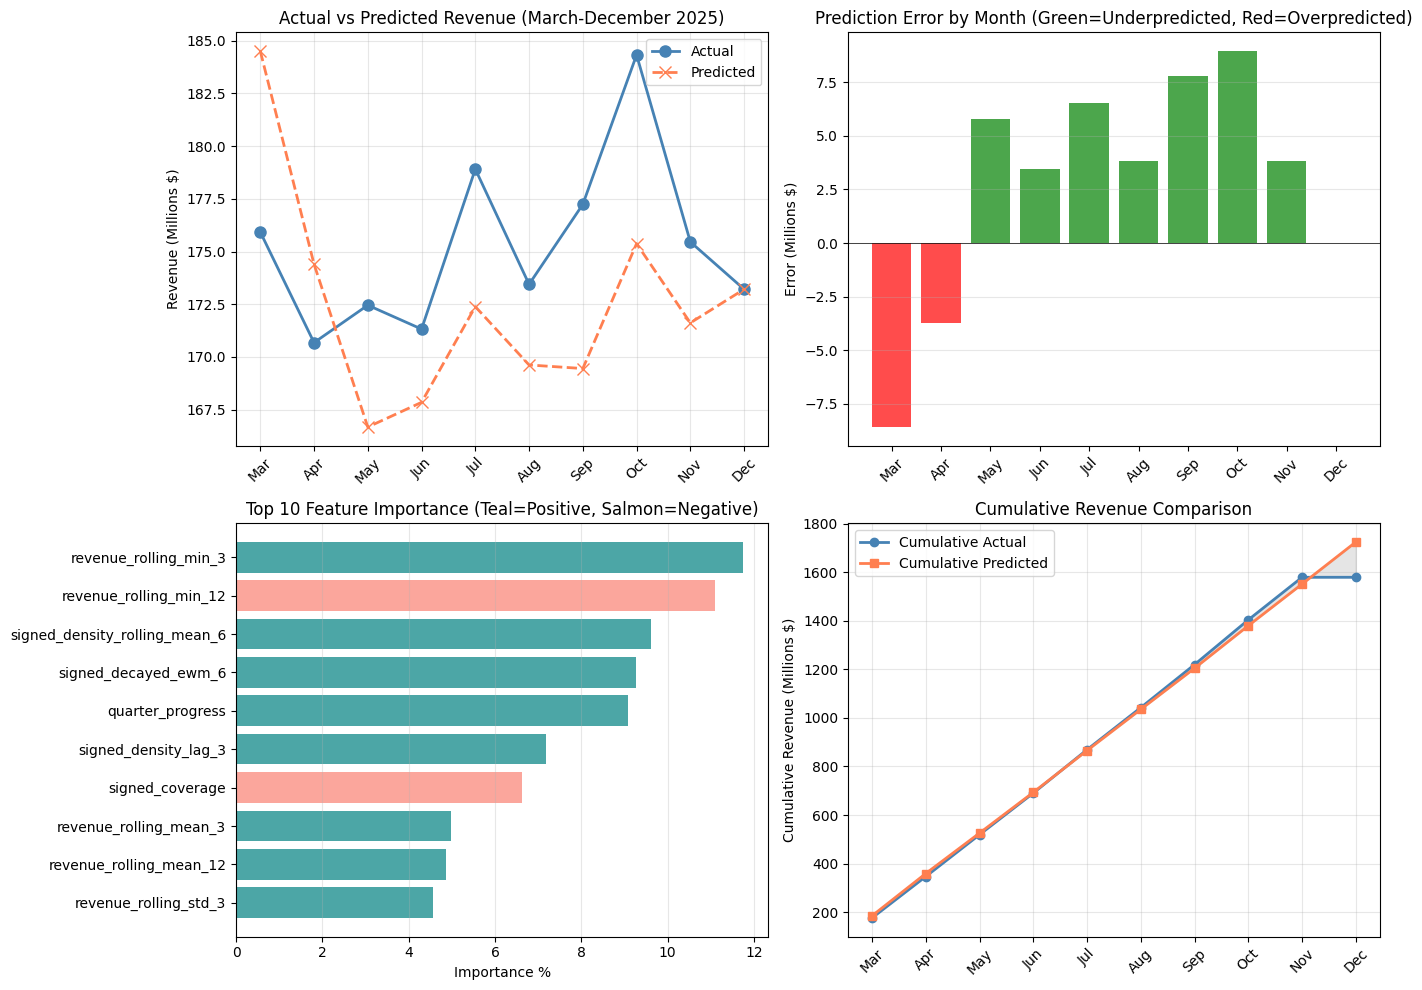

In [28]:
# Visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Actual vs Predicted (Line chart for better trend visualization)
ax1 = axes[0, 0]
months = test_data['month'].values
x_pos = range(len(months))
ax1.plot(x_pos, test_data['actual_revenue'].fillna(test_data['predicted_revenue']) / 1e6,
         marker='o', label='Actual', color='steelblue', linewidth=2, markersize=8)
ax1.plot(x_pos, test_data['predicted_revenue'] / 1e6,
         marker='x', label='Predicted', color='coral', linewidth=2, linestyle='--', markersize=8)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(months, rotation=45)
ax1.set_ylabel('Revenue (Millions $)')
ax1.set_title('Actual vs Predicted Revenue (March-December 2025)')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Error by month
ax2 = axes[0, 1]
errors = test_data['actual_revenue'] - test_data['predicted_revenue']
colors = ['green' if e >= 0 else 'red' for e in errors.fillna(0)]
ax2.bar(x_pos, errors.fillna(0) / 1e6, color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(months, rotation=45)
ax2.set_ylabel('Error (Millions $)')
ax2.set_title('Prediction Error by Month (Green=Underpredicted, Red=Overpredicted)')
ax2.grid(axis='y', alpha=0.3)

# 3. Feature importance (horizontal bar with color coding)
ax3 = axes[1, 0]
top_features = feature_importance.head(10)
colors_feat = ['teal' if c > 0 else 'salmon' for c in top_features['Coefficient'].values]
ax3.barh(range(len(top_features)), top_features['Importance_%'].values, color=colors_feat, alpha=0.7)
ax3.set_yticks(range(len(top_features)))
ax3.set_yticklabels(top_features['Feature'].values)
ax3.set_xlabel('Importance %')
ax3.set_title('Top 10 Feature Importance (Teal=Positive, Salmon=Negative)')
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# 4. Cumulative comparison
ax4 = axes[1, 1]
cum_actual = test_data['actual_revenue'].fillna(0).cumsum() / 1e6
cum_pred = test_data['predicted_revenue'].cumsum() / 1e6
ax4.plot(x_pos, cum_actual, marker='o', label='Cumulative Actual', color='steelblue', linewidth=2)
ax4.plot(x_pos, cum_pred, marker='s', label='Cumulative Predicted', color='coral', linewidth=2)
ax4.fill_between(x_pos, cum_actual, cum_pred, alpha=0.2, color='gray')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(months, rotation=45)
ax4.set_ylabel('Cumulative Revenue (Millions $)')
ax4.set_title('Cumulative Revenue Comparison')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Summary
print('\n' + '='*80)
print('SUMMARY')
print('='*80)
print(f'''
✅ MODEL: ElasticNet with GridSearchCV tuning + Bias Correction
✅ TRAINING DATA: 2023-2024 ({len(train_data)} samples)
✅ TEST DATA: March-December 2025 ({len(test_data)} months)
✅ FEATURES: {len(feature_cols)} features selected

📊 NEW FEATURES ADDED:
   - signed_decayed: Exponential decay for distant deals
   - revenue_macd: MACD-style momentum indicator
   - log_signed_monthly: Log transform of monthly run rate
   - pipeline_forecast_volatility: Pipeline stability measure
   - unsigned_monthly_run_rate: Unsigned deals per month
   - signed_coverage: Coverage ratio vs historical
   - growth_potential: Composite growth score

📊 KEY FEATURE CATEGORIES:
   - Research-based features (decay, MACD, volatility)
   - Delta features (month-to-month changes)
   - Density features (normalized by remaining months)
   - Lagged revenue features (with proper shift)
   - Rolling statistics and EWM features
   - Business intelligence metrics
   - Interaction features

🔧 UNDERPREDICTION FIX:
   - Removed high-volatility negative features
   - Applied bias correction: ${mean_residual:,.0f}
   - Added momentum and trend features

🔧 SIMULATION STRATEGY:
   - Revenue-based features: Forward Fill
   - Ratio/Density features: EWM(6) with trend continuation

📈 PERFORMANCE:
   - MAPE: {mape:.2f}% (with bias correction)
   - Bias: {bias:.2f}%
''')